This Notebook illustrates the use of the openmc.mgxs.Library class specifically for application in OpenMC's multi-group mode. This example notebook follows the same process as was done in MGXS Part III, but instead uses OpenMC as the multi-group solver. During this process, this notebook will illustrate the following features:

   - Calculation of multi-group cross sections for a fuel assembly
   - Automated creation and storage of MGXS with openmc.mgxs.Library
   - Steady-state pin-by-pin fission rates comparison between continuous-energy and multi-group OpenMC.


# Generate Input Files

In [1]:
import math
import pickle

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import os

import openmc
import openmc.mgxs

%matplotlib inline


First we need to define materials that will be used in the problem. Before defining a material, we must create nuclides that are used in the material.

In [2]:
# Instantiate some Nuclides
h1 = openmc.Nuclide('H1')
b10 = openmc.Nuclide('B10')
o16 = openmc.Nuclide('O16')
u235 = openmc.Nuclide('U235')
u238 = openmc.Nuclide('U238')
zr90 = openmc.Nuclide('Zr90')

With the nuclides we defined, we will now create three materials for the fuel, water, and cladding of the fuel pins.

In [3]:
# 1.6 enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide(u235, 3.7503e-4)
fuel.add_nuclide(u238, 2.2625e-2)
fuel.add_nuclide(o16, 4.6007e-2)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide(zr90, 7.2758e-3)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide(h1, 4.9457e-2)
water.add_nuclide(o16, 2.4732e-2)
water.add_nuclide(b10, 8.0042e-6)


With our three materials, we can now create a Materials object that can be exported to an actual XML file.

In [4]:
# Instantiate a Materials object
materials_file = openmc.Materials((fuel, zircaloy, water))

# Export to "materials.xml"
materials_file.export_to_xml()

Now let's move on to the geometry. This problem will be a square array of fuel pins and control rod guide tubes for which we can use OpenMC's lattice/universe feature. The basic universe will have three regions for the fuel, the clad, and the surrounding coolant. The first step is to create the bounding surfaces for fuel and clad, as well as the outer bounding surfaces of the problem.

In [5]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.45720)

# Create boundary planes to surround the geometry
min_x = openmc.XPlane(x0=-10.71, boundary_type='reflective')
max_x = openmc.XPlane(x0=+10.71, boundary_type='reflective')
min_y = openmc.YPlane(y0=-10.71, boundary_type='reflective')
max_y = openmc.YPlane(y0=+10.71, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')

With the surfaces defined, we can now construct a fuel pin cell from cells that are defined by intersections of half-spaces created by the surfaces.

In [6]:
# Create a Universe to encapsulate a fuel pin
fuel_pin_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
fuel_pin_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
fuel_pin_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
fuel_pin_universe.add_cell(moderator_cell)

Likewise, we can construct a control rod guide tube with the same surfaces.

In [7]:
# Create a Universe to encapsulate a control rod guide tube
guide_tube_universe = openmc.Universe(name='Guide Tube')

# Create guide tube Cell
guide_tube_cell = openmc.Cell(name='Guide Tube Water')
guide_tube_cell.fill = water
guide_tube_cell.region = -fuel_outer_radius
guide_tube_universe.add_cell(guide_tube_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='Guide Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
guide_tube_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='Guide Tube Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
guide_tube_universe.add_cell(moderator_cell)

Using the pin cell universe, we can construct a 17x17 rectangular lattice with a 1.26 cm pitch.

In [8]:
# Create fuel assembly Lattice
assembly = openmc.RectLattice(name='1.6% Fuel Assembly')
assembly.pitch = (1.26, 1.26)
assembly.lower_left = [-1.26 * 17. / 2.0] * 2

Next, we create a NumPy array of fuel pin and guide tube universes for the lattice.

In [9]:
# Create array indices for guide tube locations in lattice
template_x = np.array([5, 8, 11, 3, 13, 2, 5, 8, 11, 14, 2, 5, 8,
                       11, 14, 2, 5, 8, 11, 14, 3, 13, 5, 8, 11])
template_y = np.array([2, 2, 2, 3, 3, 5, 5, 5, 5, 5, 8, 8, 8, 8,
                       8, 11, 11, 11, 11, 11, 13, 13, 14, 14, 14])

# Initialize an empty 17x17 array of the lattice universes
universes = np.empty((17, 17), dtype=openmc.Universe)

# Fill the array with the fuel pin and guide tube universes
universes[:,:] = fuel_pin_universe
universes[template_x, template_y] = guide_tube_universe

# Store the array of universes in the lattice
assembly.universes = universes

OpenMC requires that there is a "root" universe. Let us create a root cell that is filled by the pin cell universe and then assign it to the root universe.

In [10]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = assembly

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(name='root universe', universe_id=0)
root_universe.add_cell(root_cell)

We now must create a geometry that is assigned a root universe and export it to XML.

In [11]:
# Create Geometry and set root Universe
geometry = openmc.Geometry()
geometry.root_universe = root_universe
# Export to "geometry.xml"
geometry.export_to_xml()

With the geometry and materials finished, we now just need to define simulation parameters. In this case, we will use 10 inactive batches and 40 active batches each with 5000 particles.

In [12]:
# OpenMC simulation parameters
batches = 50
inactive = 10
particles = 5000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': False}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-10.71, -10.71, -10, 10.71, 10.71, 10.]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

Let us also create a Plots file that we can use to verify that our fuel assembly geometry was created successfully.

In [13]:
# Instantiate a Plot
plot = openmc.Plot()
plot.filename = 'materials-xy'
plot.origin = [0, 0, 0]
plot.pixels = [250, 250]
plot.width = [-10.71*2, -10.71*2]
plot.color = 'mat'

# Instantiate a Plots object, add Plot, and export to "plots.xml"
plot_file = openmc.Plots([plot])
plot_file.export_to_xml()

With the plots.xml file, we can now generate and view the plot. OpenMC outputs plots in .ppm format, which can be converted into a compressed format like .png with the convert utility.

In [14]:
# Run openmc in plotting mode
openmc.plot_geometry(output=False)

0

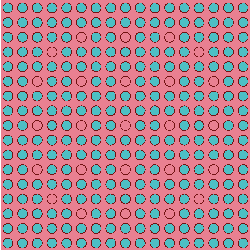

In [15]:
# Convert OpenMC's funky ppm to png
!convert materials-xy.ppm materials-xy.png

# Display the materials plot inline
Image(filename='materials-xy.png')

As we can see from the plot, we have a nice array of fuel and guide tube pin cells with fuel, cladding, and water!

# Create an MGXS Library

Now we are ready to generate multi-group cross sections! First, let's define a 2-group structure using the built-in EnergyGroups class.

In [16]:
# Instantiate a 2-group EnergyGroups object
groups = openmc.mgxs.EnergyGroups()
groups.group_edges = np.array([0., 0.625, 20.0e6])

Next, we will instantiate an openmc.mgxs.Library for the energy groups with our the fuel assembly geometry.

In [17]:
# Initialize an 2-group MGXS Library for OpenMOC
mgxs_lib = openmc.mgxs.Library(geometry)
mgxs_lib.energy_groups = groups

Now, we must specify to the Library which types of cross sections to compute. OpenMC's multi-group mode can accept isotropic flux-weighted cross sections or angle-dependent cross sections, as well as supporting anisotropic scattering represented by either Legendre polynomials, histogram, or tabular angular distributions.  At this time the MGXS Library class only supports the generation of isotropic flux-weighted cross sections and P0 scattering, so that is what will be used for this example.  Therefore, we will create the following multi-group cross sections needed to run an OpenMC simulation to verify the accuracy of our cross sections: "total", "absorption", "nu-fission", '"fission", "nu-scatter matrix", "multiplicity matrix", and "chi".
"multiplicity matrix" is needed to provide OpenMC's multi-group mode with additional information needed to accurately treat scattering multiplication (i.e., (n,xn) reactions)) explicitly.

In [18]:
# Specify multi-group cross section types to compute
mgxs_lib.mgxs_types = ['total', 'absorption', 'nu-fission', 'fission',
                       'nu-scatter matrix', 'multiplicity matrix', 'chi']

Now we must specify the type of domain over which we would like the `Library` to compute multi-group cross sections. The domain type corresponds to the type of tally filter to be used in the tallies created to compute multi-group cross sections. At the present time, the `Library` supports "material" "cell", "universe", and "mesh" domain types. In this simple example, we wish to compute multi-group cross sections only for each material and therefore will use a "material" domain type.

**Note:** By default, the `Library` class will instantiate `MGXS` objects for each and every domain (material, cell, universe, or mesh) in the geometry of interest. However, one may specify a subset of these domains to the `Library.domains` property.

In [19]:
# Specify a "cell" domain type for the cross section tally filters
mgxs_lib.domain_type = "material"

# Specify the cell domains over which to compute multi-group cross sections
mgxs_lib.domains = geometry.get_all_materials()

We will instruct the library to not compute cross sections on a nuclide-by-nuclide basis, and instead to focus on generating material-specific macroscopic cross sections.

**NOTE:** The default value of the `by_nuclide` parameter is `False`, so the following step is not necessary but is included for illustrative purposes.

In [20]:
# Do not compute cross sections on a nuclide-by-nuclide basis
mgxs_lib.by_nuclide = False

Now we will set the scattering order that we wish to use.  For this problem we will use P3 scattering.  A warning is expected telling us that the default behavior (a P0 correction on the scattering data) is over-ridden by our choice of using a Legendre expansion to treat anisotropic scattering.

In [21]:
# Set the Legendre order to 3 for P3 scattering
mgxs_lib.legendre_order = 3

/home/romano/openmc/openmc/mgxs/library.py:370: RuntimeWarning: The P0 correction will be ignored since the scattering order 0 is greater than zero
  warn(msg, RuntimeWarning)


Now that the `Library` has been setup, lets make sure it contains the types of cross sections which meet the needs of OpenMC's multi-group solver.  Note that this step is done automatically when writing the Multi-Group Library file later in the process (as part of the `mgxs_lib.write_mg_library()`), but it is a good practice to also run this before spending all the time running OpenMC to generate the cross sections.

In [22]:
# Check the library - if no errors are raised, then the library is satisfactory.
mgxs_lib.check_library_for_openmc_mgxs()

Lastly, we use the `Library` to construct the tallies needed to compute all of the requested multi-group cross sections in each domain and nuclide.

In [23]:
# Construct all tallies needed for the multi-group cross section library
mgxs_lib.build_library()

The tallies can now be export to a "tallies.xml" input file for OpenMC.

**NOTE:** At this point the `Library` has constructed nearly 100 distinct Tally objects. The overhead to tally in OpenMC scales as O(N) for N tallies, which can become a bottleneck for large tally datasets. To compensate for this, the Python API's `Tally`, `Filter` and `Tallies` classes allow for the smart merging of tallies when possible. The `Library` class supports this runtime optimization with the use of the optional `merge` parameter (`False` by default) for the `Library.add_to_tallies_file(...)` method, as shown below.

In [24]:
# Create a "tallies.xml" file for the MGXS Library
tallies_file = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies_file, merge=True)

In addition, we instantiate a fission rate mesh tally to compare with the multi-group result.

In [25]:
# Instantiate a tally Mesh
mesh = openmc.Mesh()
mesh.type = 'regular'
mesh.dimension = [17, 17]
mesh.lower_left = [-10.71, -10.71]
mesh.upper_right = [+10.71, +10.71]

# Instantiate tally Filter
mesh_filter = openmc.MeshFilter(mesh)

# Instantiate the Tally
tally = openmc.Tally(name='mesh tally')
tally.filters = [mesh_filter]
tally.scores = ['fission']

# Add tally to collection
tallies_file.append(tally, merge=True)

# Export all tallies to a "tallies.xml" file
tallies_file.export_to_xml()

Time to run the calculation and get our results!

In [26]:
# Run OpenMC
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

To make the files available and not be over-written when running the multi-group calculation, we will now rename the statepoint and summary files.

In [27]:
# Move the StatePoint File
ce_spfile = './ce_statepoint.h5'
os.rename('statepoint.' + str(batches) + '.h5', ce_spfile)
# Move the Summary file
ce_sumfile = './ce_summary.h5'
os.rename('summary.h5', ce_sumfile)

# Tally Data Processing

Our simulation ran successfully and created statepoint and summary output files.  Let's begin by loading the StatePoint file, but not automatically linking the summary file.

In [28]:
# Load the statepoint file, but not the summary file, as it is a different filename than expected.
sp = openmc.StatePoint(ce_spfile, autolink=False)

In addition to the statepoint file, our simulation also created a summary file which encapsulates information about the materials and geometry. This is necessary for the `openmc.mgxs` module to properly process the tally data. We first create a `Summary` object and link it with the statepoint.  Normally this would not need to be performed, but since we have renamed our summary file to avoid conflicts with the Multi-Group calculation's summary file, we will load this in explicitly.

In [29]:
su = openmc.Summary(ce_sumfile)
sp.link_with_summary(su)

The statepoint is now ready to be analyzed by the `Library`. We simply have to load the tallies from the statepoint into the `Library` and our `MGXS` objects will compute the cross sections for us under-the-hood.

In [30]:
# Initialize MGXS Library with OpenMC statepoint data
mgxs_lib.load_from_statepoint(sp)

The next step will be to prepare the input for OpenMC to use our newly created multi-group data.

# Multi-Group OpenMC Calculation

We will now use the `Library` to produce a multi-group cross section data set for use by the OpenMC multi-group solver.  
Note that since this simulation included so few histories, it is reasonable to expect some divisions by zero errors.  This will show up as a runtime warning in the following step.

In [31]:
# Create a MGXS File which can then be written to disk
mgxs_file = mgxs_lib.create_mg_library(xs_type='macro', xsdata_names=['fuel', 'zircaloy', 'water'])

# Write the file to disk using the default filename of `mgxs.h5`
mgxs_file.export_to_hdf5()

OpenMC's multi-group mode uses the same input files as does the continuous-energy mode (materials, geometry, settings, plots ,and tallies file).  Differences would include the use of a flag to tell the code to use multi-group transport, a location of the multi-group library file, and any changes needed in the materials.xml and geometry.xml files to re-define materials as necessary (for example, if using a macroscopic cross section library instead of individual microscopic nuclide cross sections as is done in continuous-energy, or if multiple cross sections exist for the same material due to the material existing in varied spectral regions).

Since this example is using material-wise macroscopic cross sections without considering that the neutron energy spectra and thus cross sections may be changing in space, we only need to modify the materials.xml and settings.xml files.  If the material names and ids are not otherwise changed, then the geometry.xml file does not need to be modified from its continuous-energy form.  The tallies.xml file will be left untouched as it currently contains the tally types that we will need to perform our comparison. 

First we will create the new materials.xml file.

In [32]:
# Instantiate our Macroscopic Data
fuel_macro = openmc.Macroscopic('fuel')
zircaloy_macro = openmc.Macroscopic('zircaloy')
water_macro = openmc.Macroscopic('water')

# Now re-define our materials to use the Multi-Group macroscopic data
# instead of the continuous-energy data.
# 1.6 enriched fuel UO2
fuel = openmc.Material(name='UO2')
fuel.add_macroscopic(fuel_macro)

# cladding
zircaloy = openmc.Material(name='Clad')
zircaloy.add_macroscopic(zircaloy_macro)

# moderator
water = openmc.Material(name='Water')
water.add_macroscopic(water_macro)

# Finally, instantiate our Materials object
materials_file = openmc.Materials((fuel, zircaloy, water))

# Set the location of the cross sections file
materials_file.cross_sections = './mgxs.h5'

# Export to "materials.xml"
materials_file.export_to_xml()

No geometry file neeeds to be written as the continuous-energy file is correctly defined for the multi-group case as well.

Next, we can make the changes we need to the settings file.
These changes are limited to telling OpenMC we will be running a multi-group calculation and pointing to the location of our multi-group cross section file.

In [33]:
# Set the energy mode
settings_file.energy_mode = 'multi-group'

# Export to "settings.xml"
settings_file.export_to_xml()

Finally, since we want similar tally data in the end, we will leave our pre-existing `tallies.xml` file for this calculation.

At this point, the problem is set up and we can run the multi-group calculation.

In [34]:
# Run the Multi-Group OpenMC Simulation
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

# Results Comparison
Now we can compare the multi-group and continuous-energy results.

We will begin by loading the multi-group statepoint file we just finished writing and extracting the calculated keff.
Since we did not rename the summary file, we do not need to load it separately this time.

In [35]:
# Load the last statepoint file and keff value
mgsp = openmc.StatePoint('statepoint.' + str(batches) + '.h5')
mg_keff = mgsp.k_combined

Next, we can load the continuous-energy eigenvalue for comparison.

In [36]:
ce_keff = sp.k_combined

Lets compare the two eigenvalues, including their bias

In [37]:
bias = 1.0E5 * (ce_keff[0] - mg_keff[0])

print('Continuous-Energy keff = {0:1.6f}'.format(ce_keff[0]))
print('Multi-Group keff = {0:1.6f}'.format(mg_keff[0]))
print('bias [pcm]: {0:1.1f}'.format(bias))

Continuous-Energy keff = 1.024739
Multi-Group keff = 1.025941
bias [pcm]: -120.2


This shows a small but nontrivial pcm bias between the two methods.  Some degree of mismatch is expected simply to the very few histories being used in these example problems.  An additional mismatch is always inherent in the practical application of multi-group theory due to the high degree of approximations inherent in that method.

# Flux and Pin Power Visualizations

Next we will visualize the mesh tally results obtained from both the Continuous-Energy and Multi-Group OpenMC calculations.

First, we extract volume-integrated fission rates from the Multi-Group calculation's mesh fission rate tally for each pin cell in the fuel assembly.

In [38]:
# Get the OpenMC fission rate mesh tally data
mg_mesh_tally = mgsp.get_tally(name='mesh tally')
mg_fission_rates = mg_mesh_tally.get_values(scores=['fission'])

# Reshape array to 2D for plotting
mg_fission_rates.shape = (17,17)

# Normalize to the average pin power
mg_fission_rates /= np.mean(mg_fission_rates)

Now we can do the same for the Continuous-Energy results.

In [39]:
# Get the OpenMC fission rate mesh tally data
ce_mesh_tally = sp.get_tally(name='mesh tally')
ce_fission_rates = ce_mesh_tally.get_values(scores=['fission'])

# Reshape array to 2D for plotting
ce_fission_rates.shape = (17,17)

# Normalize to the average pin power
ce_fission_rates /= np.mean(ce_fission_rates)

Now we can easily use Matplotlib to visualize the two fission rates side-by-side.

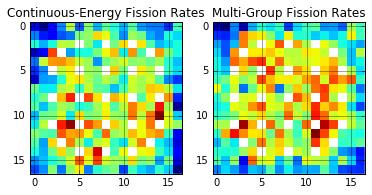

In [40]:
# Force zeros to be NaNs so their values are not included when matplotlib calculates
# the color scale
ce_fission_rates[ce_fission_rates == 0.] = np.nan
mg_fission_rates[mg_fission_rates == 0.] = np.nan

# Plot the CE fission rates in the left subplot
fig = plt.subplot(121)
plt.imshow(ce_fission_rates, interpolation='none', cmap='jet')
plt.title('Continuous-Energy Fission Rates')

# Plot the MG fission rates in the right subplot
fig2 = plt.subplot(122)
plt.imshow(mg_fission_rates, interpolation='none', cmap='jet')
plt.title('Multi-Group Fission Rates')


We also see good agreement between the fission rate distributions, though these should converge closer together with an increasing number of particle histories in both the continuous-energy run to generate the multi-group cross sections, and in the multi-group calculation itself.